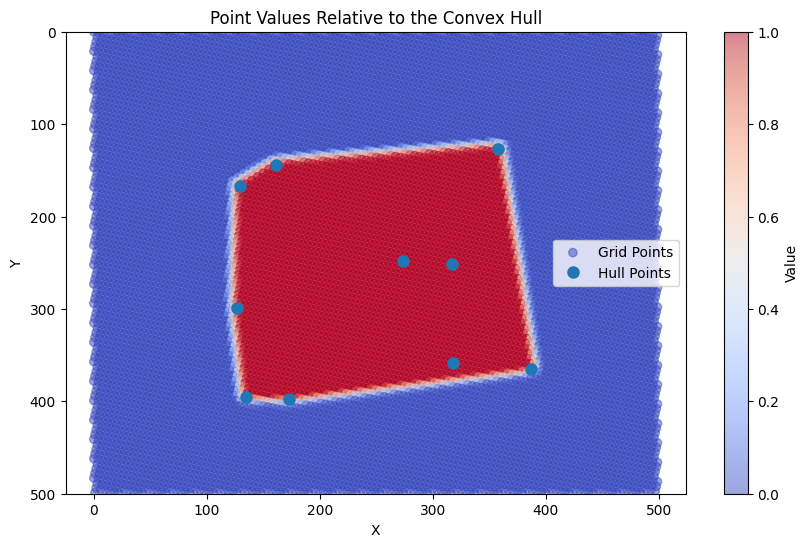

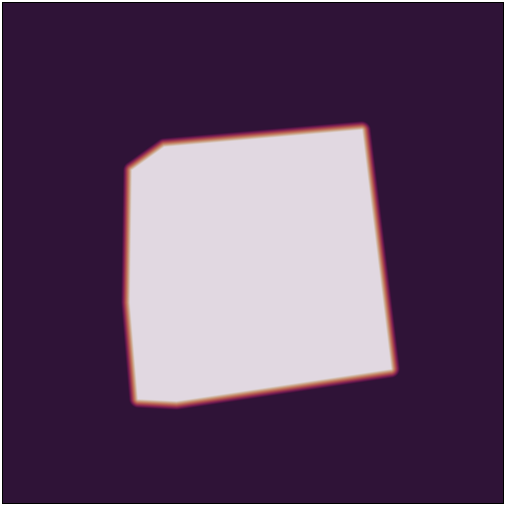

In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, Delaunay


def point_line_distance_vectorized(points, line_start, line_end):
    # This function is intended to handle multiple points at once for a single line segment
    line_vec = line_end - line_start
    line_len = np.linalg.norm(line_vec)
    line_unitvec = line_vec / line_len
    points_vec = points - line_start
    points_proj_length = np.dot(points_vec, line_unitvec)
    points_proj_length_clipped = np.clip(points_proj_length, 0, line_len)
    nearest_points = line_start + np.outer(points_proj_length_clipped, line_unitvec)
    distances = np.linalg.norm(points - nearest_points, axis=1)
    return distances

def get_hull_values(points_for_hull, shape):
    
    h, w = shape
    x = np.arange(w)
    y = np.arange(h)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
    
    hull = ConvexHull(points_for_hull)
    delaunay = Delaunay(points_for_hull[hull.vertices])
    is_inside = delaunay.find_simplex(grid_points) >= 0
    values = np.zeros(grid_points.shape[0])
    lambda_param = 10

    # For each edge in the hull, compute the distance from all grid points to the edge
    for edge in hull.simplices:
        line_start = points_for_hull[edge[0]]
        line_end = points_for_hull[edge[1]]
        distances = point_line_distance_vectorized(grid_points, line_start, line_end)
        if 'min_distances' not in locals():
            min_distances = distances
        else:
            min_distances = np.minimum(min_distances, distances)

    # Compute values for each point outside the hull
    values[~is_inside] = np.maximum(1 - min_distances[~is_inside] / lambda_param, 0)
    values[is_inside] = 1
    return values


def visualize(points_for_hull, values, shape):
    h, w = shape
    x = np.arange(w)
    y = np.arange(h)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(grid_points[::21][:, 0], grid_points[::21][:, 1], c=values[::21], cmap='coolwarm', alpha=0.5, label='Grid Points')
    plt.colorbar(label='Value')
    plt.plot(points_for_hull[:, 0], points_for_hull[:, 1], 'o', markersize=8, label='Hull Points')
    # for simplex in hull.simplices:
    #     plt.plot(points_for_hull[simplex, 0], points_for_hull[simplex, 1], 'k-')

    plt.legend()
    plt.title('Point Values Relative to the Convex Hull')
    plt.ylim(500, 0)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()



shape = (500, 500)
points = np.random.randint(100, 400, size=(10, 2))
values = get_hull_values(points, shape)
mask = torch.tensor(values).reshape(shape)
visualize(points, values, shape)
mask.chans